# Gaussian process emulation
This notebook visualises the sampling of parameter space, uses R to create GP emulators,     
validates the emulators, makes new predictions and then uses Sobols to calculate the importance of each parameter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn
import pandas as pd
from scipy.stats import sobol_indices, uniform
import os
os.environ['R_HOME'] = '/home/users/eers/miniforge3/envs/sct_env/lib/R'
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import sys
sys.path.append('py_scripts')
import emulator_plots as emplt

In [2]:
SMALL_SIZE = 18
MEDIUM_SIZE = 22
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def make_unit(column, col_min, col_max):
    unit_column = np.zeros(np.shape(column))
    unit_column = (column - col_min)/(col_max - col_min)
    return unit_column

## Visualise parameter inputs

In [4]:
transition_time = np.loadtxt("data/output_data/transition_time_output.csv", delimiter=',', skiprows=1)
rwp_mean = np.loadtxt("data/output_data/rwp_mean_output.csv", delimiter=',', skiprows=1)
inputs = pd.read_csv("data/input_data/post_spinup_inputs.csv")
inputs['baut'] = 10**inputs['baut']

In [5]:
mins = [min(inputs[column]) for column in inputs.columns]
maxs = [max(inputs[column]) for column in inputs.columns]

In [6]:
unit_inputs = inputs.copy()
for i, column in enumerate(inputs.columns):
    unit_inputs[column] = make_unit(inputs[column], mins[i], maxs[i])

# CHECK!
if np.any(unit_inputs) > 1.0 or np.any(unit_inputs) < 0.0:
    print("STOP: unit transformation has not worked.")

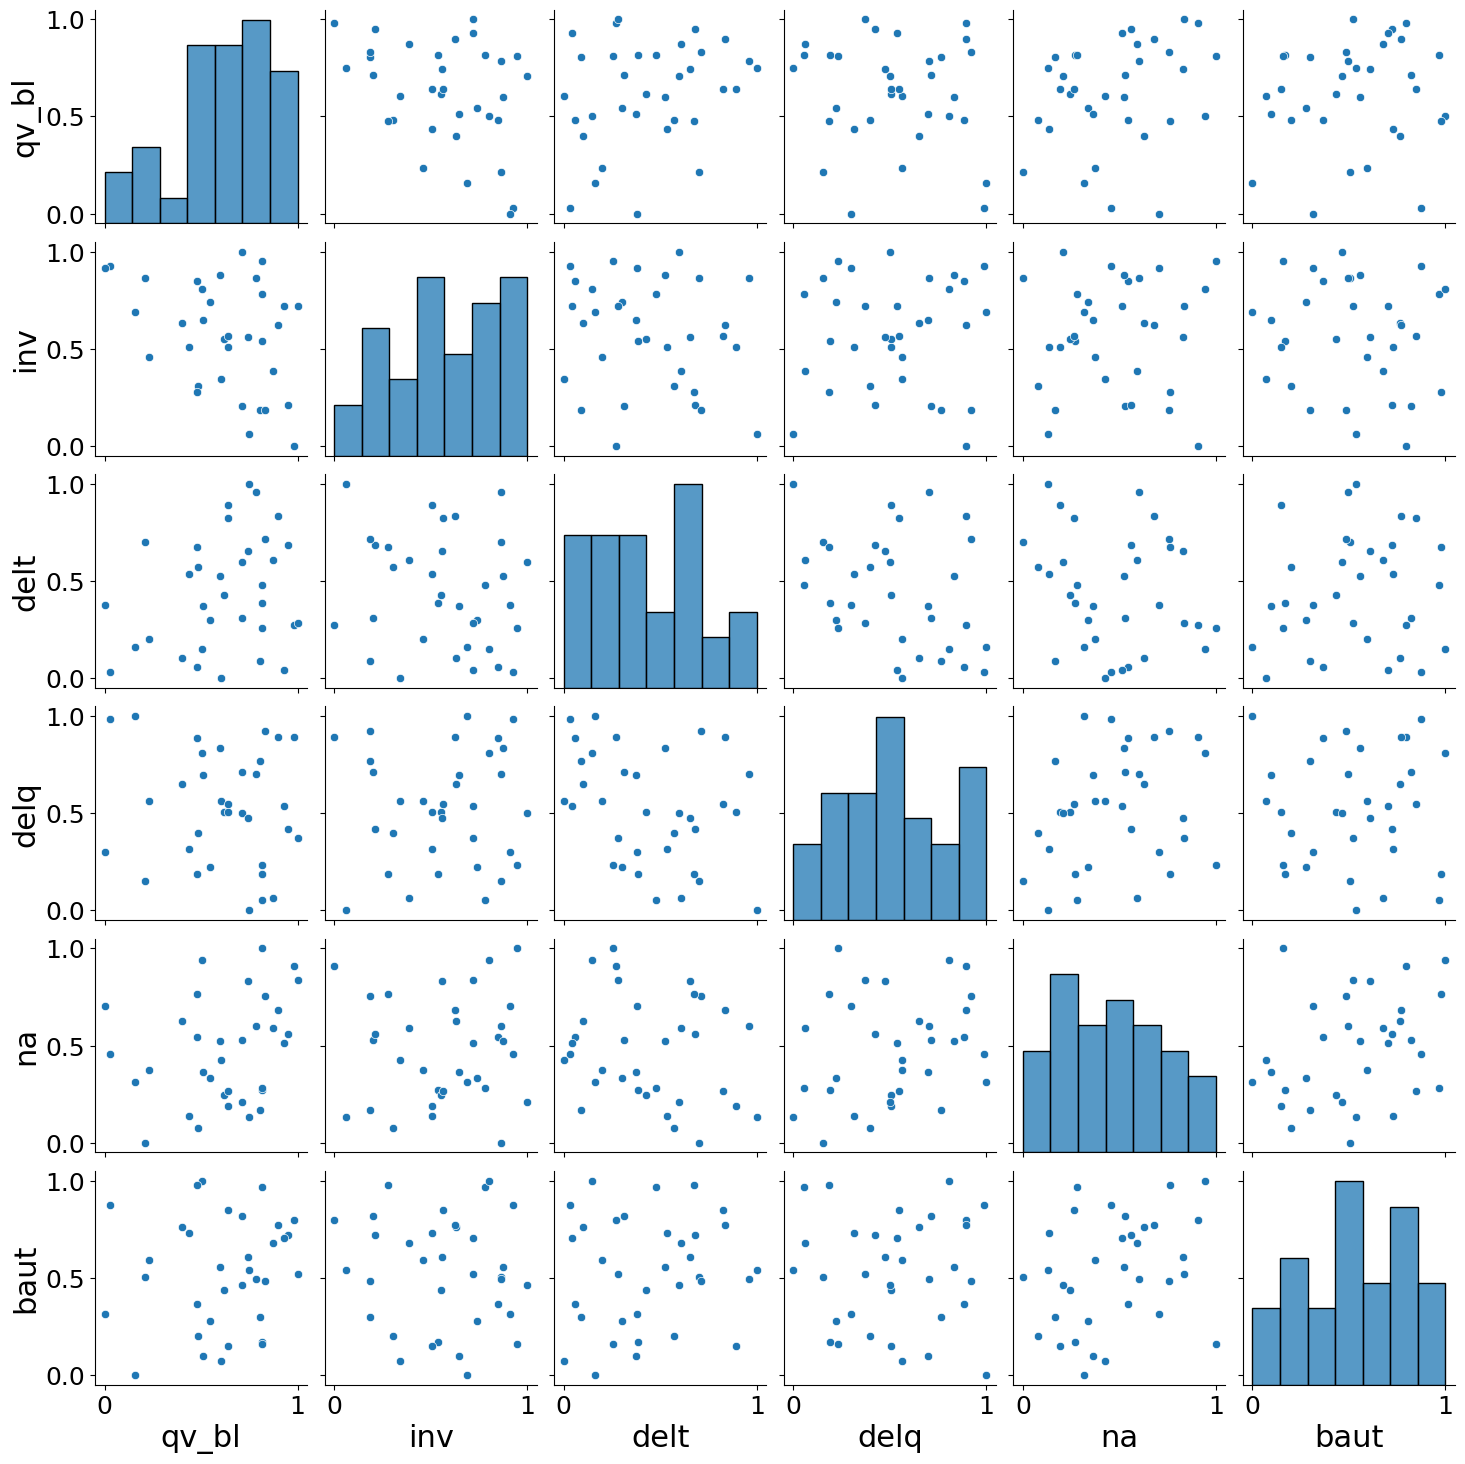

In [7]:
seaborn.pairplot(unit_inputs)

## Call emulator in R

In [7]:
importr('DiceKriging')
rlist = ro.r['list']
rmatrix = ro.r['matrix']

In [8]:
def worker_km(response, design, nugget=None, nv=None, trend=None, var=None, sigma=None):
    ro.globalenv["response"] = ro.FloatVector(response)
    if nv is not None:
        ro.globalenv["nv"] = ro.FloatVector(nv)

    df = ro.r["data.frame"]([ro.FloatVector(design[column]) for column in design])
    df.names = [column for column in design]
    ro.globalenv["design"] = df
    ro.globalenv["bfgs"] = "BFGS"
    
    if nugget is None:
        if trend is None:
            model = ro.r("model = km(formula=~.,design=design, response=response,optim.method=bfgs,"
                              "covtype='matern5_2', control=list(maxit=500))")
        else:
            ro.globalenv["trend"] = trend
            ro.globalenv["var"] = var
            ro.globalenv["sigma"] = sigma
            model = ro.r("model = km(formula=~.,design=design, response=response,optim.method=bfgs,"
                              "covtype='matern5_2',coef.trend=trend, coef.cov = var, coef.var=sigma, control=list(maxit=500))")
    elif nugget=='noise':
        if trend is None:
            model = ro.r("model = km(formula=~.,design=design, response=response,noise.var=nv,optim.method=bfgs,"
                          "covtype='matern5_2',control=list(maxit=500))")
        else:
            ro.globalenv["trend"] = trend
            ro.globalenv["var"] = var
            ro.globalenv["sigma"] = sigma
            model = ro.r("model = km(formula=~.,design=design, response=response,noise.var=nv,optim.method=bfgs,"
                          "covtype='matern5_2',coef.trend=trend, coef.cov = var, coef.var=sigma, control=list(maxit=500))")
    elif nugget=='nugget':
        nugget_value = 0.369799353412748
        ro.globalenv["nugget_value"] = nugget_value
        model = ro.r("model = km(formula=~.,design=design, response=response,nugget=nugget_value,optim.method=bfgs,"
                          "covtype='matern5_2',coef.trend=trend,control=list(maxit=500))")
    return model

In [9]:
def predictor(model, new_design):
    ro.globalenv["model"] = model

    df = ro.r["data.frame"]([ro.FloatVector(new_design[column]) for column in new_design])
    df.names = [column for column in new_design]
    ro.globalenv["new_design"] = df

    ro.globalenv["k_type"] = "UK"
    return ro.r("predictions = predict(object=model, newdata=new_design, type=k_type, light.return=TRUE, checkNames=FALSE)")

## No noise

In [214]:
tt_model = worker_km(transition_time, unit_inputs)
tt_loo = ro.r["leaveOneOut.km"](tt_model, "UK")


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~qv_bl + inv + delt + delq + na + baut
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  2 2 2 2 2 2 
  - best initial criterion value(s) :  -131.1847 

N = 6, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       131.18  |proj g|=      0.45101
At iterate     1  f =        130.6  |proj g|=        1.0094
At iterate     2  f =       130.34  |proj g|=        1.4849
At iterate     3  f =       130.17  |proj g|=        1.6153
At iterate     4  f =       129.86  |proj g|=         1.581
At iterate     5  f =       129.81  |proj g|=        1.9019
At iterate     6  f =       129.75  |proj g|=         1.515
At iterate     7  f =       129.72  |proj g|=        1.2732
At iterate     8  f =     

In [215]:
rwp_model = worker_km(rwp_mean, unit_inputs)
rwp_loo = ro.r["leaveOneOut.km"](rwp_model, "UK")


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~qv_bl + inv + delt + delq + na + baut
* covariance model : 
  - type :  matern5_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 1e-10 1e-10 1e-10 1e-10 1e-10 
  - parameters upper bounds :  2 2 2 2 2 2 
  - best initial criterion value(s) :  -61.96454 

N = 6, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       61.965  |proj g|=       1.7419
At iterate     1  f =       61.635  |proj g|=        1.4499
At iterate     2  f =       61.001  |proj g|=        1.0476
At iterate     3  f =       57.825  |proj g|=        1.9527
At iterate     4  f =       57.735  |proj g|=        1.7833
At iterate     5  f =       57.437  |proj g|=        1.7215
At iterate     6  f =       57.244  |proj g|=        1.9493
At iterate     7  f =       57.146  |proj g|=        1.6902
At iterate     8  f =     

### Plot leave-one-out validation

Ratio check: 1.36
Ratio check: 3.05


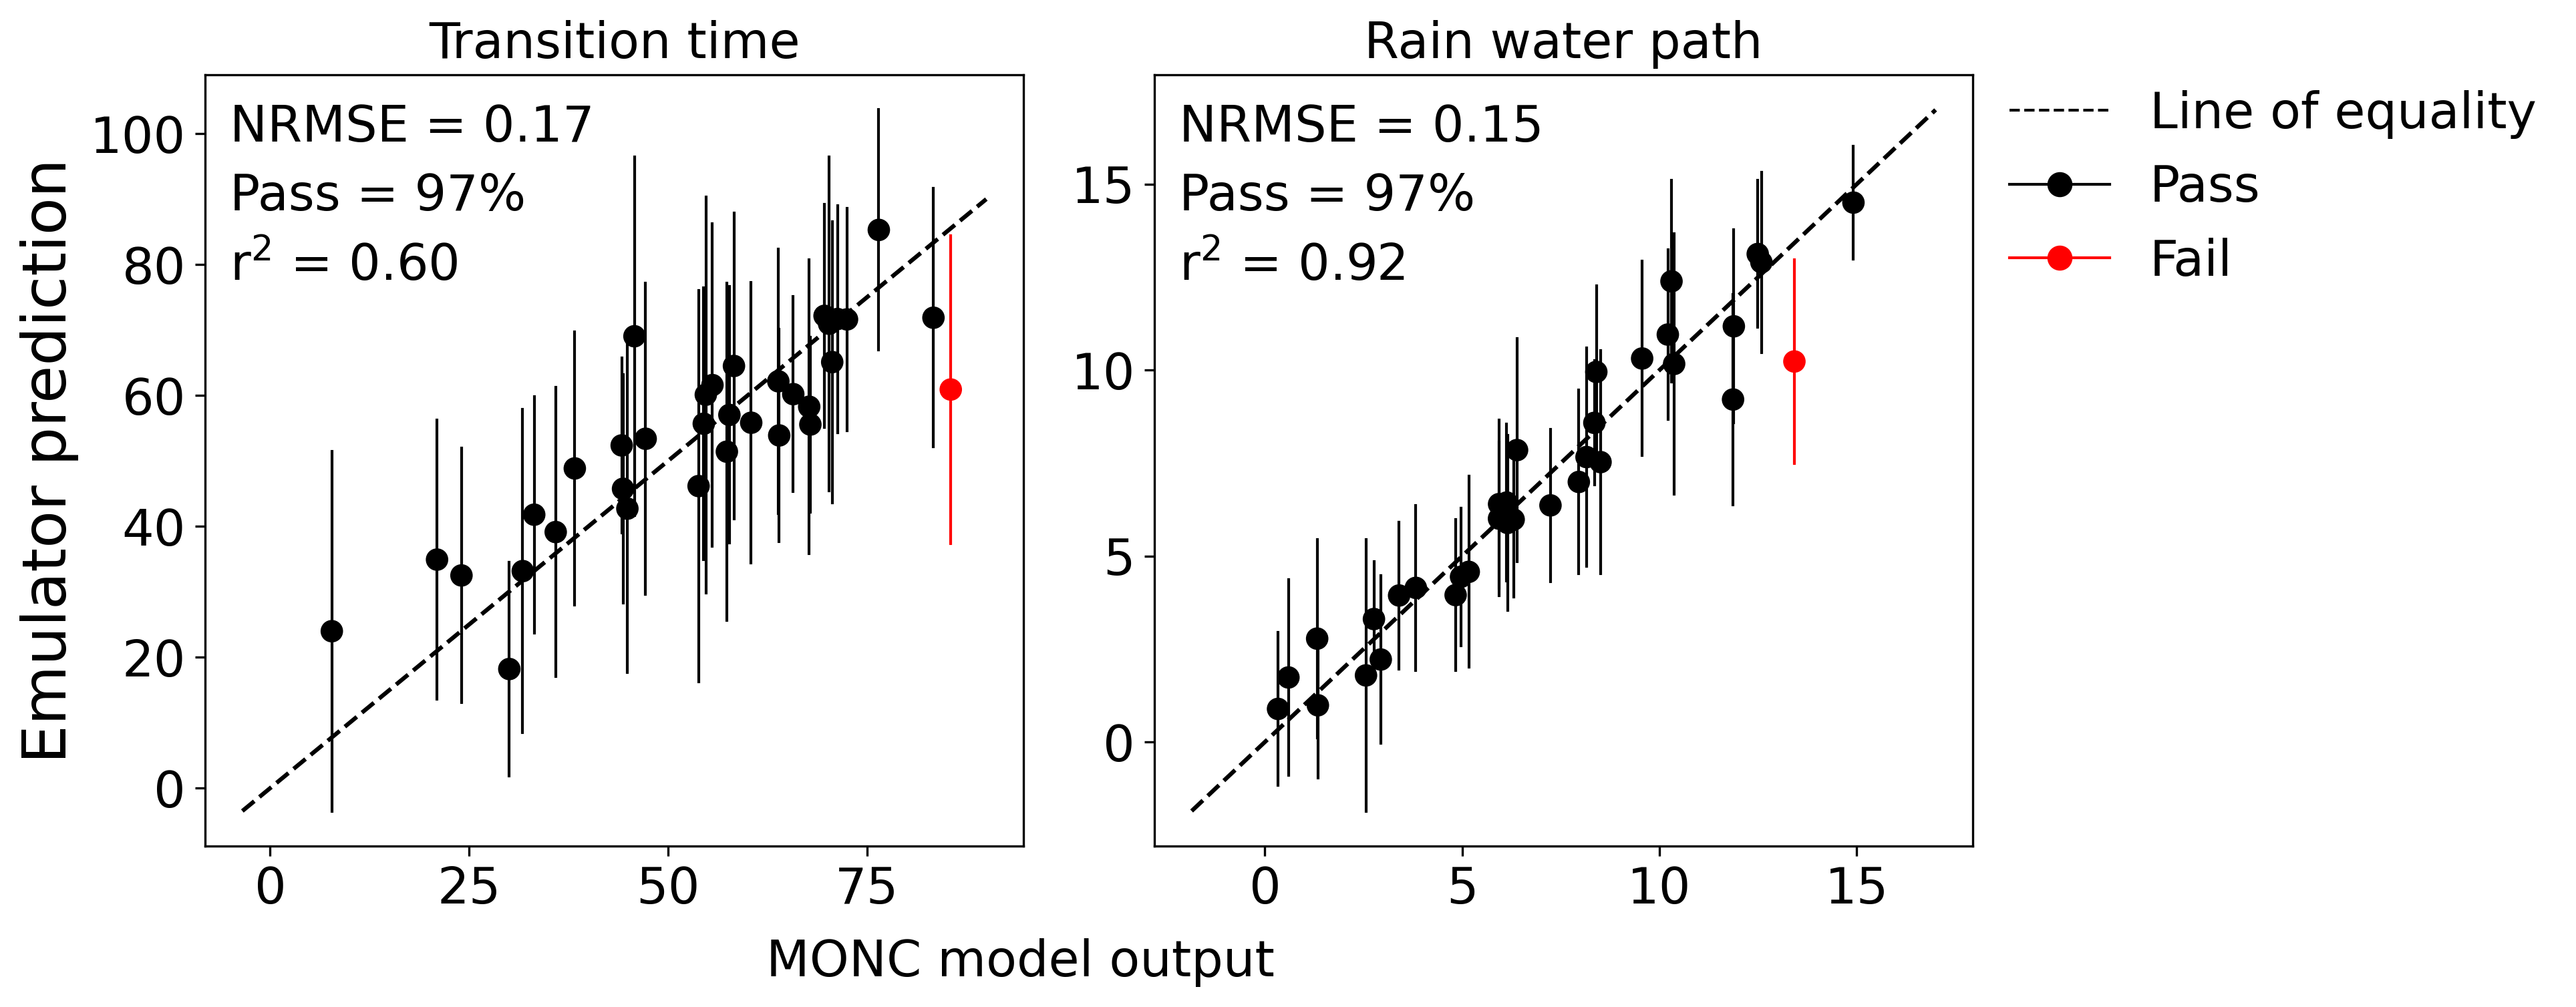

In [216]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5),dpi=300)
plt.subplots_adjust(left=0.12,bottom=0.15, top=0.92, right=0.75, wspace=0.16)

for i, (training_data, loo_prediction, label, max_line) in enumerate(zip([transition_time, rwp_mean], [tt_loo, rwp_loo],
                                                        ["Transition time", "Rain water path"], [90, 17])):      
    mean = np.array(loo_prediction[0])
    sd = np.array(loo_prediction[1])
    rmse = emplt.plot_validation(ax[i], loo_prediction, training_data, max_line, label, font_size=SMALL_SIZE)
    
    total_mean = np.mean(mean)
    nrmse = rmse/total_mean

    meanstd = np.mean(sd)
    std_dots = np.std(mean)
    print(f"Ratio check: {std_dots/meanstd:0.2f}")

ax[0].set_ylabel("Emulator prediction")
fig.text(0.32, 0.02,"MONC model output")

black_line = mlines.Line2D([], [], color='black', marker='o',markersize=8, linewidth=1)
red_line = mlines.Line2D([], [], color='red', marker='o',markersize=8, linewidth=1)
line_of_equality = mlines.Line2D([], [], color='black', linestyle='--', linewidth=1)

ax[1].legend(handles=[line_of_equality, black_line, red_line], labels=["Line of equality", "Pass","Fail"],loc=(1.02,0.7), frameon=False)

fig.savefig("figures/loo_val_both_outputs_no_noise.png", facecolor='white', dpi=300)
fig.savefig("figures/loo_val_both_outputs_no_noise.pdf", facecolor='white', dpi=300)

## With noise

In [10]:
def loo_with_noise(response, unit_inputs, nv, trend, var, sigma):
    loo_predictions = np.zeros((len(response), 5))

    for i in range(len(response)):
        response_i = np.delete(response, i)
        nv_i = np.delete(nv, i)
        unit_inputs_i = unit_inputs.drop(i)
        model = worker_km(response_i, unit_inputs_i, nugget="noise", nv=nv_i, trend=trend, var=var, sigma=sigma)
        predictions = predictor(model, unit_inputs.iloc[[i]])
        loo_predictions[i] = np.column_stack((predictions[0], predictions[1], predictions[2], predictions[3], predictions[4]))
    return loo_predictions

In [35]:
%%capture
tt_nv = np.loadtxt("noise_files/nv_transition_time.csv", delimiter=',', skiprows=1)
tt_model = worker_km(transition_time, unit_inputs, nugget="noise", nv=tt_nv)
tt_trend = tt_model.slots["trend.coef"]
tt_cov = tt_model.slots["covariance"]
tt_var = tt_cov.slots["range.val"]
tt_sigma = tt_cov.slots["sd2"]
tt_loo_arr = loo_with_noise(transition_time, unit_inputs, tt_nv, tt_trend, tt_var, tt_sigma)
tt_loo = [tt_loo_arr[:,1], tt_loo_arr[:,2]]

In [11]:
%%capture
rwp_nv = np.loadtxt("noise_files/nv_rwp_mean.csv", delimiter=',', skiprows=1)
rwp_model = worker_km(rwp_mean, unit_inputs, nugget="noise", nv=rwp_nv)
rwp_trend = rwp_model.slots["trend.coef"]
rwp_cov = rwp_model.slots["covariance"]
rwp_var = rwp_cov.slots["range.val"]
rwp_sigma = rwp_cov.slots["sd2"]
rwp_loo_arr = loo_with_noise(rwp_mean, unit_inputs, rwp_nv, rwp_trend, rwp_var, rwp_sigma)
rwp_loo = [rwp_loo_arr[:,1], rwp_loo_arr[:,2]]

### Plot LOO

Ratio check: 1.43
Ratio check: 2.45


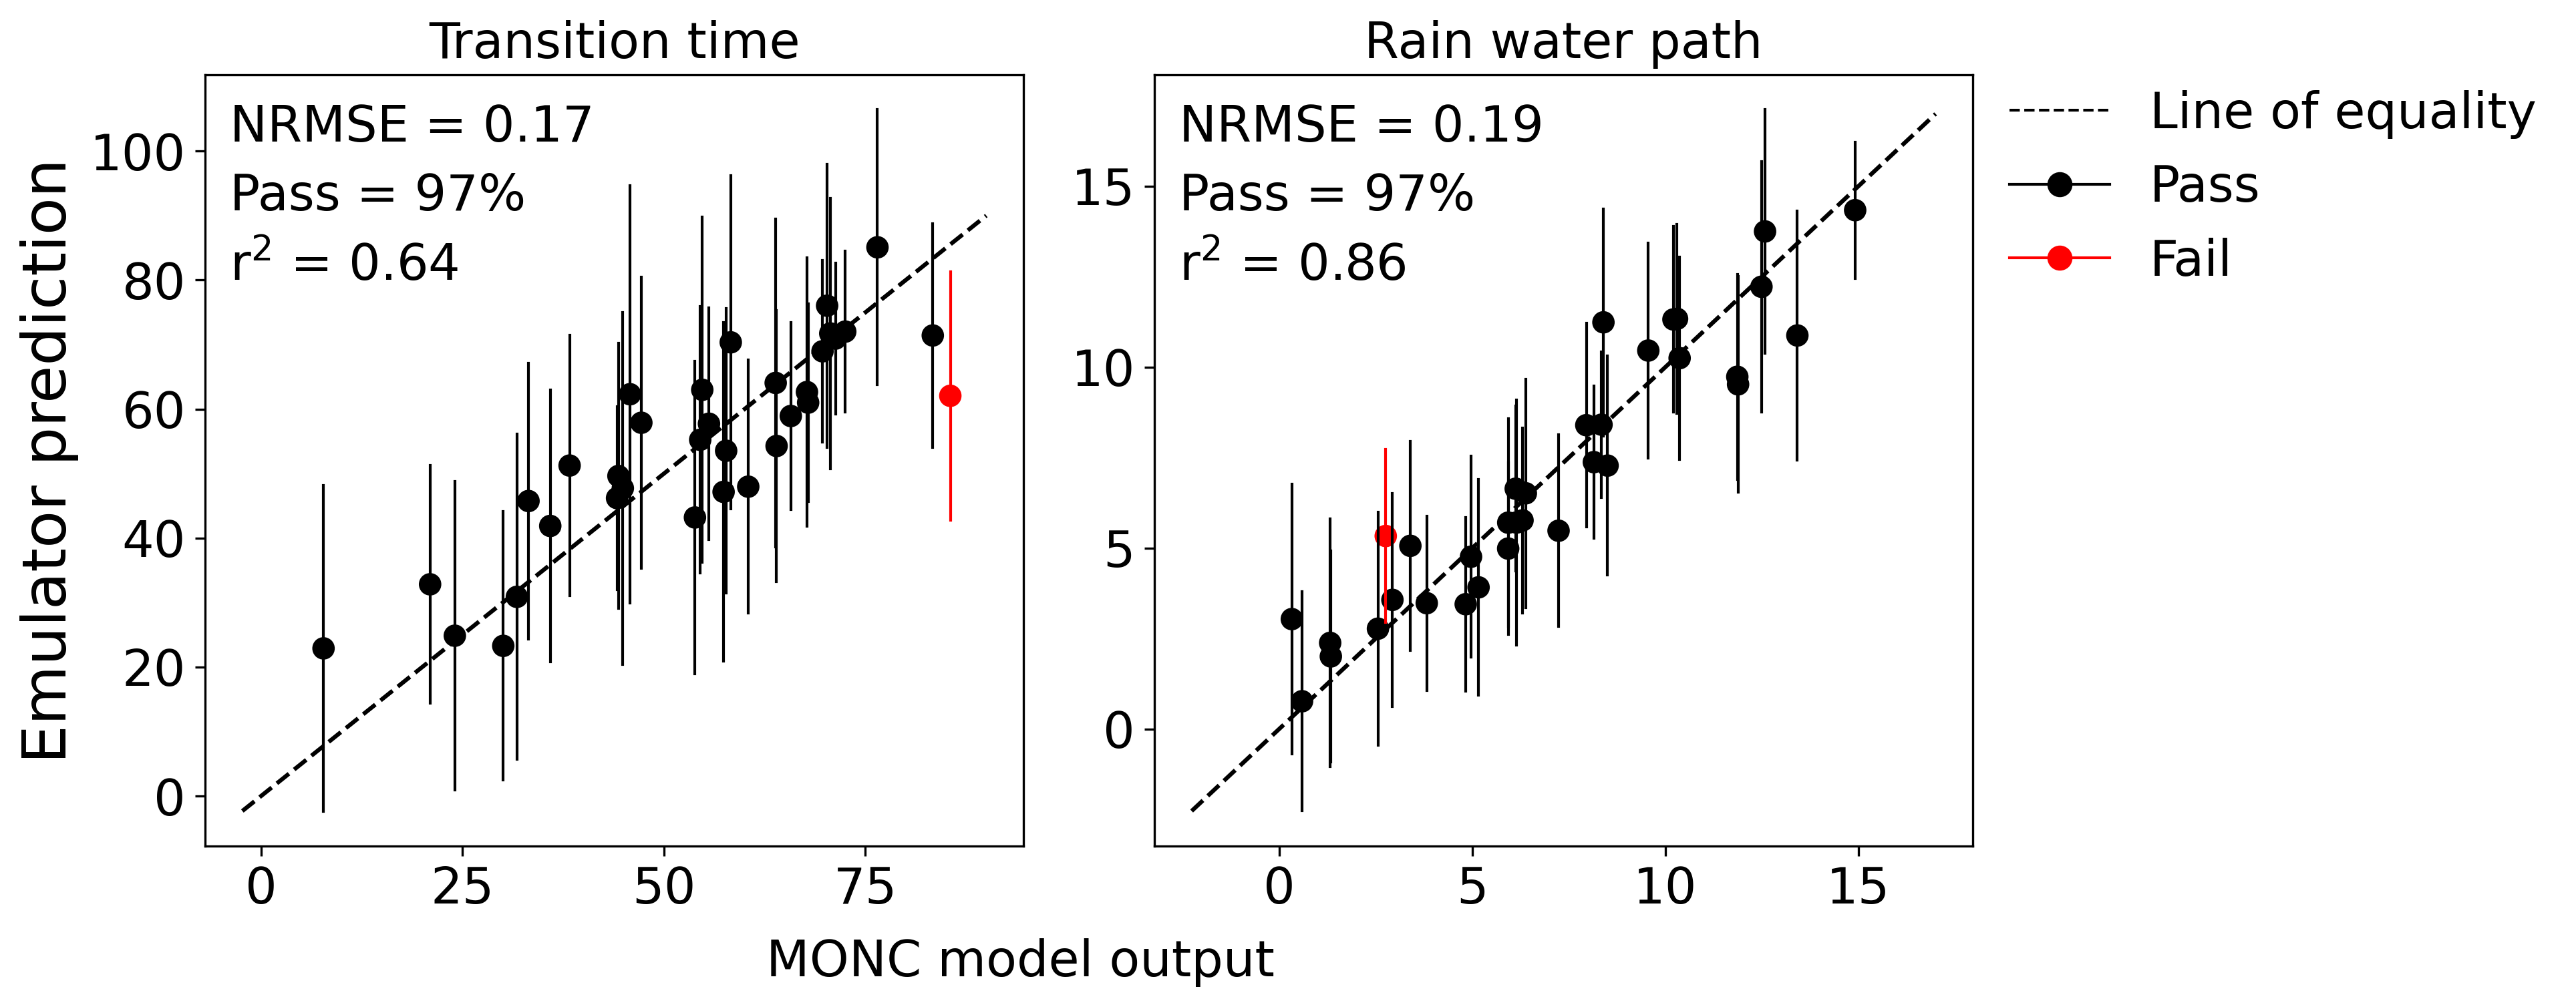

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5),dpi=300)
plt.subplots_adjust(left=0.12,bottom=0.15, top=0.92, right=0.75, wspace=0.16)

for i, (training_data, loo_prediction, label, max_line) in enumerate(zip([transition_time, rwp_mean], [tt_loo, rwp_loo],
                                                        ["Transition time", "Rain water path"], [90, 17])):      
    mean = np.array(loo_prediction[0])
    sd = np.array(loo_prediction[1])
    rmse = emplt.plot_validation(ax[i], loo_prediction, training_data, max_line, label, font_size=SMALL_SIZE)
    
    total_mean = np.mean(mean)
    nrmse = rmse/total_mean

    meanstd = np.mean(sd)
    std_dots = np.std(mean)
    print(f"Ratio check: {std_dots/meanstd:0.2f}")

ax[0].set_ylabel("Emulator prediction")
fig.text(0.32, 0.02,"MONC model output")

black_line = mlines.Line2D([], [], color='black', marker='o',markersize=8, linewidth=1)
red_line = mlines.Line2D([], [], color='red', marker='o',markersize=8, linewidth=1)
line_of_equality = mlines.Line2D([], [], color='black', linestyle='--', linewidth=1)

ax[1].legend(handles=[line_of_equality, black_line, red_line], labels=["Line of equality", "Pass","Fail"],loc=(1.02,0.7), frameon=False)

fig.savefig("figures/loo_val_both_outputs_noise.png", facecolor='white', dpi=300)
fig.savefig("figures/loo_val_both_outputs_noise.pdf", facecolor='white', dpi=300)

In [37]:
# np.savetxt("predictions/loo/transition_time_loo_pred.csv", tt_loo_arr[:,1], delimiter=',', header='mean', comments='')
# np.savetxt("predictions/loo/rwp_mean_loo_pred.csv", rwp_loo_arr[:,1], delimiter=',', header='mean', comments='')

## Make predictions

### Latin hypercube design

In [38]:
new_inputs = pd.read_csv("predictions/lh1000_design.csv")
new_inputs['baut'] = 10**new_inputs['baut']
new_unit_inputs = new_inputs.copy()
for i, column in enumerate(new_unit_inputs.columns):
    new_unit_inputs[column
        ] = make_unit(new_unit_inputs[column], mins[i], maxs[i])

tt_predictions = predictor(tt_model, new_unit_inputs)
rwp_predictions = predictor(rwp_model, new_unit_inputs)

# np.savetxt("predictions/lh1000_transition_time_nv.csv", np.column_stack((tt_predictions[0], tt_predictions[1], tt_predictions[2], tt_predictions[3], tt_predictions[4])), delimiter=',', header='trend,mean,sd,lower95,upper95')
# np.savetxt("predictions/lh1000_rwp_mean_nv.csv", np.column_stack((rwp_predictions[0], rwp_predictions[1], rwp_predictions[2], rwp_predictions[3], rwp_predictions[4])), delimiter=',', header='trend,mean,sd,lower95,upper95')

### Grid design

In [39]:
new_inputs = pd.read_csv("predictions/grid10_design.csv")
new_inputs['baut'] = 10**new_inputs['baut']
new_unit_inputs = new_inputs.copy()
for i, column in enumerate(new_unit_inputs.columns):
    new_unit_inputs[column] = make_unit(new_unit_inputs[column], mins[i], maxs[i])

tt_predictions = predictor(tt_model, new_unit_inputs)
rwp_predictions = predictor(rwp_model, new_unit_inputs)

# np.savetxt("predictions/grid10_transition_time_nv.csv", np.column_stack((tt_predictions[0], tt_predictions[1], tt_predictions[2], tt_predictions[3], tt_predictions[4])), delimiter=',', header='trend,mean,sd,lower95,upper95')
# np.savetxt("predictions/grid10_rwp_mean_nv.csv", np.column_stack((rwp_predictions[0], rwp_predictions[1], rwp_predictions[2], rwp_predictions[3], rwp_predictions[4])), delimiter=',', header='trend,mean,sd,lower95,upper95')

## Sensitivity analysis

In [16]:
def sa_predictor(inputs):
    df = ro.r["data.frame"]([ro.FloatVector(row) for row in inputs])
    df.names = ["na" for row in inputs]
    ro.globalenv["new_design"] = df
    predictions = ro.r["predict"](object=sa_model, newdata=df, type="UK", checkNames=False)
    return predictions[1]

names = ['$\mathrm{BL}\,\mathit{q}_{\mathrm{v}}$', '$\mathrm{BL}\,\mathit{z}$', r'$\Delta\theta$', 
        '$\Delta\mathit{q}_{\mathrm{v}}$', '$\mathrm{BL}\,\mathit{N}_{\mathrm{a}}$', '10$^{b_{\mathrm{aut}}}$']

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_646/4006921437.py:8: SyntaxWarning: invalid escape sequence '\m'
  names = ['$\mathrm{BL}\,\mathit{q}_{\mathrm{v}}$', '$\mathrm{BL}\,\mathit{z}$', r'$\Delta\theta$',
/tmp/ipykernel_646/4006921437.py:8: SyntaxWarning: invalid escape sequence '\m'
  names = ['$\mathrm{BL}\,\mathit{q}_{\mathrm{v}}$', '$\mathrm{BL}\,\mathit{z}$', r'$\Delta\theta$',
/tmp/ipykernel_646/4006921437.py:9: SyntaxWarning: invalid escape sequence '\D'
  '$\Delta\mathit{q}_{\mathrm{v}}$', '$\mathrm{BL}\,\mathi

### Transition time

In [19]:
%%capture
reps = 10

main_results_mean = np.zeros((reps,6))
total_results_mean = np.zeros((reps,6))
for rep in range(reps):
    global sa_model
    sa_model = worker_km(transition_time, unit_inputs, nugget="noise", nv=tt_nv)
    
    distlist = [uniform()]*unit_inputs.shape[1]
    result = sobol_indices(func=sa_predictor,dists=distlist,n=1024)
    main_results_mean[rep] = result.first_order
    total_results_mean[rep] = result.total_order

Mean interactions are: 6.71%
$\mathrm{BL}\,\mathit{q}_{\mathrm{v}}$ has average main effect contribution of 0.91%
$\mathrm{BL}\,\mathit{z}$ has average main effect contribution of 6.74%
$\Delta\theta$ has average main effect contribution of 8.58%
$\Delta\mathit{q}_{\mathrm{v}}$ has average main effect contribution of 2.21%
$\mathrm{BL}\,\mathit{N}_{\mathrm{a}}$ has average main effect contribution of 60.50%
10$^{b_{\mathrm{aut}}}$ has average main effect contribution of 14.35%


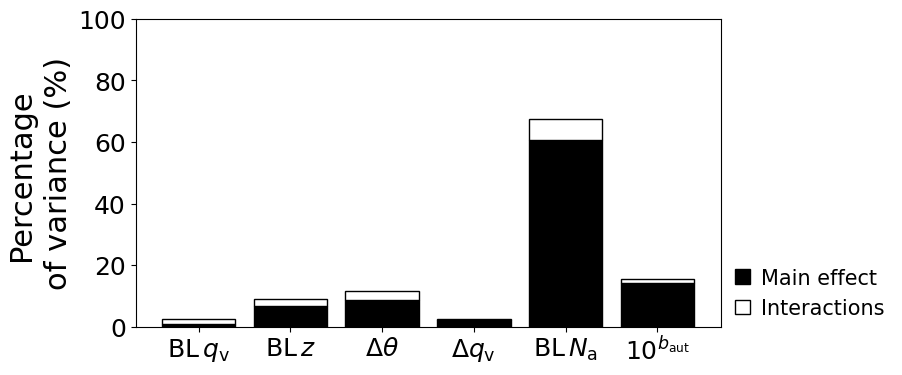

In [21]:
main_effect = np.mean(main_results_mean, axis=0)
total_effect = np.mean(total_results_mean, axis=0)
mean_interactions = np.mean([(1-sum(row)) for row in main_results_mean])
print(f"Mean interactions are: {mean_interactions*100:0.2f}%")

fig, ax = plt.subplots(figsize=(9,4))
ax = emplt.plot_sa_bars(ax, main_effect, total_effect, names)

np.savetxt("sa_output/sobols_transition_time.csv",np.column_stack((main_effect, total_effect)), delimiter=',', header="Mean main effect,Mean total effect", comments='')
fig.savefig("figures/sa_transition_time.png")
fig.savefig("figures/sa_transition_time.pdf")

### Rain water path

In [22]:
%%capture
reps = 10

main_results_mean = np.zeros((reps,6))
total_results_mean = np.zeros((reps,6))
for rep in range(reps):
    global sa_model
    sa_model = worker_km(rwp_mean, unit_inputs, nugget="noise", nv=rwp_nv)

    distlist = [uniform()]*unit_inputs.shape[1]
    result = sobol_indices(func=sa_predictor,dists=distlist,n=1024)
    main_results_mean[rep] = result.first_order
    total_results_mean[rep] = result.total_order

Mean interactions are: 1.50%
$\mathrm{BL}\,\mathit{q}_{\mathrm{v}}$ has average main effect contribution of 10.65%
$\mathrm{BL}\,\mathit{z}$ has average main effect contribution of 35.06%
$\Delta\theta$ has average main effect contribution of 0.30%
$\Delta\mathit{q}_{\mathrm{v}}$ has average main effect contribution of 11.06%
$\mathrm{BL}\,\mathit{N}_{\mathrm{a}}$ has average main effect contribution of 22.16%
10$^{b_{\mathrm{aut}}}$ has average main effect contribution of 19.26%


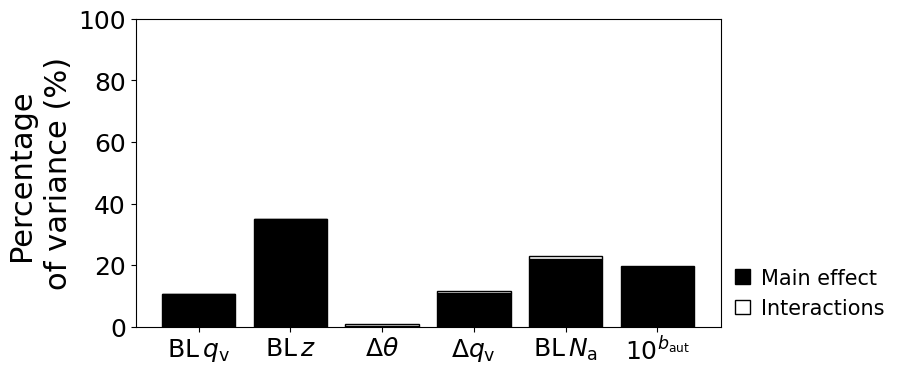

In [24]:
main_effect = np.mean(main_results_mean, axis=0)
total_effect = np.mean(total_results_mean, axis=0)
mean_interactions = np.mean([(1-sum(row)) for row in main_results_mean])
print(f"Mean interactions are: {mean_interactions*100:0.2f}%")

fig, ax = plt.subplots(figsize=(9,4))
ax = emplt.plot_sa_bars(ax, main_effect, total_effect, names)

np.savetxt("sa_output/sobols_rwp_mean.csv",np.column_stack((main_effect, total_effect)), delimiter=',', header="Mean main effect,Mean total effect", comments='')
fig.savefig("figures/sa_rwp_mean.png")
fig.savefig("figures/sa_rwp_mean.pdf")